Overview: 
Builds a local Spark workflow to explore the Sparkify event log and extract a few concrete insights:

Loads the JSON log file into a Spark DataFrame and inspects schema + summary stats.
Adds an hour column (from the millisecond timestamp) and computes songs played per hour, then plots the hourly distribution.
Cleans the data by dropping rows with missing userId/sessionId and counts how many rows are removed.
Flags downgrade events by creating a downgrade indicator column and shows those records.

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, hour, dayofweek, month, year, to_timestamp, col, count
from pyspark.sql.types import IntegerType, StringType

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("Data Wrangling Excercise").getOrCreate()
configs = spark.sparkContext.getConf().getAll()
print(configs)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/08 18:17:39 WARN Utils: Your hostname, YanghangtekiiMac.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.88 instead (on interface en1)
26/02/08 18:17:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/08 18:17:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.driver.host', '10.0.0.88'), ('spark.rdd.compress', 'True'), ('spark.hadoop.fs.s3a.vectored.read.min.seek.size', '128K'), ('spark.sql.artifact.isolation.enabled', 'false'), ('spark.executor.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-modules=jdk.incubator.vector --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UN

In [ ]:
# Read in the data
file_path = print(os.getcwd())
input_file_path = os.path.join(".","data","sparkify_log_small.json")
df = spark.read.json(input_file_path)

/Users/yanghanghuang/Desktop/nd027-Data-Engineering-Data-Lakes-AWS-Exercises-main/lesson-2-spark-essentials/exercises/concept3-data-wrangling-with-spark/solution


In [5]:
# Data Exploration
print(df.take(5))
df.describe().show()
df.printSchema()
df.describe("length").show()
print(f"{df.count()} rows in the dataset")

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'), Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'), Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstName

26/02/08 18:17:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [6]:
#Data Wrangling
# Select the page column, drop the duplicates, and sort by page
valid_page = df.select("page").dropDuplicates().sort("page")
print(valid_page.take(5))

# Select data for all pages where userId is 1046
page_user1046 = df.select("page").where(df.userId == "1046")
print(page_user1046.take(5))

[Row(page='About'), Row(page='Downgrade'), Row(page='Error'), Row(page='Help'), Row(page='Home')]
[Row(page='NextSong'), Row(page='NextSong'), Row(page='NextSong'), Row(page='NextSong'), Row(page='NextSong')]


In [7]:
# Hourly statistics
df_with_hour = df.withColumn(
    "hour",
    hour(to_timestamp((col("ts") / 1000).cast("timestamp")))
)
df_with_hour.show(3)



+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  14|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shrevep

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  249|
|   2|  216|
|   3|  228|
|   4|  251|
|   5|  339|
|   6|  462|
|   7|  479|
|   8|  484|
|   9|  430|
|  10|  362|
|  11|  295|
|  12|  257|
|  13|  248|
|  14|  369|
|  15|  375|
|  16|  456|
|  17|  454|
|  18|  382|
|  19|  302|
+----+-----+
only showing top 20 rows


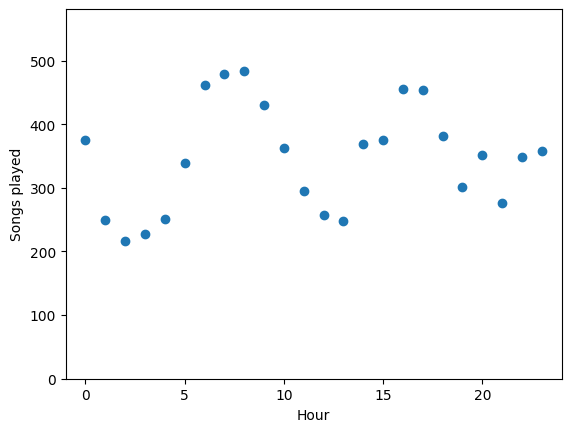

In [ ]:
# Select just the NextSong page to understand how many songs are played in each hour of the day.

songs_in_hour_df = df_with_hour.filter(df_with_hour.page == "NextSong") \
    .groupby(df_with_hour.hour) \
    .count() \
    .orderBy(df_with_hour.hour.cast("float"))

songs_in_hour_df.show()

songs_in_hour_pd = songs_in_hour_df.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()



In [16]:
# # Drop Rows with Missing Values
print(f"{df.count()} rows before dropping rows with null userId or sessionId")

# How many are there now that we dropped rows with null userId or sessionId?
df_no_missing = df.dropna(how="any", subset=["userId", "sessionId"])
print(f"{df_no_missing.count()} rows after dropping rows with null userId or sessionId")

# select all unique user ids into a dataframe
df_unique_users = df_no_missing.dropDuplicates(["userId"])
print(f"{df_unique_users.count()} unique users in the dataset")
df_unique_users.show(5)

# Select only data for where the userId column isn't an empty string (different from null)
df_no_empty = df_no_missing.filter(df_no_missing.userId != "")
print(f"{df_no_empty.count()} rows after dropping empty userId values")
df_no_empty.show(5)

10000 rows before dropping rows with null userId or sessionId
10000 rows after dropping rows with null userId or sessionId
964 unique users in the dataset
+-----------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|     artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-----------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       NULL|Logged Out|     NULL|  NULL|            0|    NULL|     NULL| free|                NULL|   PUT|   Login|         NULL|     5598|         NULL|   307|1513721196284|                NULL|      |
|OneRepublic| Logged In| 

In [28]:
# # Users Downgrade Their Accounts
# 
# Find when users downgrade their accounts and then show those log entries. 
# if_downgrade = df_no_empty.where(df_no_empty.page == "Submit Downgrade")
if_downgrade = df_no_empty.filter(df_no_empty.page == "Submit Downgrade")
print(f"{if_downgrade.count()} rows where users downgraded their accounts")
if_downgrade.show(5)


# Create a user defined function to return a 1 if the record contains a downgrade
func_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

# Select data including the user defined function
user_downgrade_df = df_no_empty.withColumn("downgrade_event", func_downgrade(col("page")))
user_downgrade_df.show(5)


# Partition by user id
# Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.
window_downgrade = pyspark.sql.Window.partitionBy("userId").orderBy("ts").rowsBetween(pyspark.sql.Window.unboundedPreceding, 0)

# Fsum is a cumulative sum over a window - in this case a window showing all events for a user
# Add a column called phase, 0 if the user hasn't downgraded yet, 1 if they have
user_downgrade_df = user_downgrade_df.withColumn("phase", pyspark.sql.functions.sum("downgrade_event").over(window_downgrade))
user_downgrade_df.orderBy(col("phase").desc()).show(5)

#phase >=1 will be 1 (integer) and phase < 1 will be 0 (integer)
user_downgrade_df = user_downgrade_df.withColumn("phase", (col("phase") >= 1).cast(IntegerType()))
user_downgrade_df.orderBy(col("phase").desc()).show(5)

# Show the phases for user 1138 
user_downgrade_df.select("phase").where(col("userId") == "1138").show()

1 rows where users downgraded their accounts
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  NULL|Logged In|    Kelly|     F|           24|  Newton|  NULL| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|NULL|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+---------